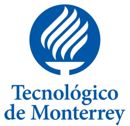

# Master in Applied Artificial Intelligence
## TC 5033 Advanced Machine Learning Methods
### Tecnológico de Monterrey
### Prof José Antonio Cantoral Ceballos
# Activity 2c
## Exploring Transfer Learning with CIFAR-10

## Team 18
Team members

> - Francisco Javier Parga García A01794380
> - Matthias Sibrian Illescas A01794249
> - Enrique Hernández García A01793727
> - Alejandro Tomás Mackey A01164338

# TC 5033
## Deep Learning
## Transfer Learning

<br>

#### Activity 2c: Exploring Transfer Learning with CIFAR-10
<br>

- Objective:

    In this activity, you'll study the concept of Transfer Learning, a powerful technique to improve the performance of your models by leveraging pre-trained architectures. The provided notebook offers a complete solution using a specific pre-trained model on the CIFAR-10 dataset. Your task is to extend this by trying out two other pre-trained models.
    
- Instructions:

    This activity should be submitted in the same format as previous activities. Remember to include the names of all team members in a markdown cell at the beginning of the notebook. The grade obtained in this notebook will be averaged with that of Activity 2b, for the grade of Activity 2.    

    Study the Provided Code: The provided notebook has a complete Transfer Learning solution using a particular pre-trained model. Make sure you understand the flow of the code and the role of each component.

    Select Two Other Pre-trained Models: Choose two different pre-trained models available in PyTorch's model zoo.

    Apply Transfer Learning: Add cells to implement Transfer Learning using the two models you've chosen. Train these models on the CIFAR-10 dataset.

    Evaluation: After training, evaluate your models' performance. Compare the results with the provided solution and try to interpret why there might be differences.

    Documentation: In a markdown cell, summarize your findings. Include any challenges you faced, how you overcame them, and any interesting insights you gained from comparing the different pre-trained models.

- Note:

    Although the provided code serves as a guide, you're encouraged to implement the new solutions on your own. The goal is to reinforce your understanding of Transfer Learning and how to apply it effectively.




In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

In [2]:
import matplotlib.pyplot as plt

### Descargar sets de datos

In [3]:
import os 

master_folder = os.path.split(os.path.split(os.getcwd())[0])[0]
class_folder = 'MNA-2023-September_Advanced_Machine_Learning_Methods'
activity_folder = "Activity 2b - Building a CNN for CIFAR10 Dataset with PyTorch" 
data_folder = 'data'

DATA_PATH = os.path.join(master_folder, class_folder, activity_folder, data_folder)
DATA_PATH

'C:\\Users\\fgarcia24\\OneDrive - Schlumberger\\Python\\fco-parga\\mna\\MNA-2023-September_Advanced_Machine_Learning_Methods\\Activity 2b - Building a CNN for CIFAR10 Dataset with PyTorch\\data'

In [4]:
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64
transform_imagenet = T.Compose([
                T.Resize(224),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_imagenet)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_imagenet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
#for i, (x, y) in enumerate(val_loader):
#    print(i, x.shape, y.shape)

### Usar GPU

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


### Mostrar imágenes

In [7]:
# This function plots a single image from the CIFAR-10 dataset
def plot_figure(image):
    plt.figure(figsize=(3,3))
    # Transpose the image to have the correct shape for displaying
    plt.imshow(np.transpose(image,(1,2,0)))
    # Turn off the axis labels
    plt.axis('off')
    # Show the plot
    plt.show()

La imagen muestreada representa un: Car


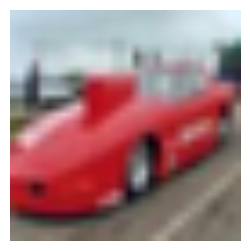

In [8]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Randomly select an index from the test loader
rnd_sample_idx = np.random.randint(len(test_loader))
# Print the class name of the image at the selected index
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
# Get the image at the selected index
image = test_loader.dataset[rnd_sample_idx][0]
# Normalize the image to have values between 0 and 1
image = (image - image.min()) / (image.max() -image.min() )
# Call the function to plot the image
plot_figure(image)

### Calcular Accuracy

In [9]:
def accuracy(model, loader):
    # Initialize the number of correct predictions and the total number of predictions
    num_correct = 0
    num_total = 0
    # Set the model to evaluation mode
    model.eval()
    # Move the model to the device (CPU or GPU)
    model = model.to(device=device)
    # Disable gradient computation to speed up the inference
    with torch.no_grad():
        # Loop over each batch of data in the loader
        for (xi, yi) in loader:
            # Move the input and output data to the device
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            # Get the model's scores (logits) for each class
            scores = model(xi) #
            # Get the predicted class by finding the maximum score along the dimension 1
            _, pred = scores.max(dim=1) 
            # Count how many predictions are correct by comparing them with the true labels
            num_correct += (pred == yi).sum()
            # Count the total number of predictions
            num_total += pred.size(0)
        # Return the accuracy as the ratio of correct predictions to total predictions
        return float(num_correct)/num_total

### Cargar modelo pre-cargado

Define a model as a pre-trained ResNet-18, which is a deep neural network architecture for image recognition

In [10]:
model_resnet18 = models.resnet18(weights=True)

C:\Users\fgarcia24\Anaconda3\envs\mna\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Exploremos el modelo

In [11]:
# Loop over each parameter of the ResNet-18 model
for i, w in enumerate(model_resnet18.parameters()):
    # Print the index, shape, and gradient requirement of the parameter
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [12]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Ajustar a nuestro modelo

Define a model as a copy of the ResNet-18 model, but without the last layer

The last layer of the ResNet-18 model is a linear layer that maps the features to 1000 classes

In [13]:
model_aux = nn.Sequential(*list(model_resnet18.children()))
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

##### Remove last layer

By removing the last layer, we can use the model as a feature extractor for other tasks

In [14]:
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

In [15]:
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [16]:
# Loop over each parameter of the model_aux
for i, parameter in enumerate(model_aux.parameters()):
    # Set the gradient requirement of the parameter to False
    # This means that the parameter will not be updated during the training process
    # This is useful when we want to freeze the weights of the pre-trained model and only train the new layers that we add
    parameter.requires_grad = False

In [17]:
# Display the updated parameters
for i, parameter in enumerate(model_aux.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False


### Loop de entrenamiento

In [18]:
def train(model, optimizer, epochs=100):
    # Initialize two lists to store the cost and accuracy values for each epoch
    costo_list = []
    acc_list = []
    
    # Move the model to the device (CPU or GPU)
    model = model.to(device=device)
    # Loop over the number of epochs
    for epoch in range(epochs):
        # Get the start time of the epoch
        start_epoch = time.time()
        
        # Loop over each batch of data in the training loader
        for i, (xi, yi) in enumerate(train_loader):
            # Set the model to training mode
            model.train()
            # Move the input and output data to the device
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)

            # Zero out the gradients of the optimizer
            optimizer.zero_grad()
            # Get the model's scores (logits) for each class
            scores = model(xi)

            # Calculate the cross-entropy loss between the scores and the true labels
            cost = F.cross_entropy(input= scores, target=yi)
                 
            # Compute the gradients of the loss with respect to the model's parameters
            cost.backward()
            # Update the model's parameters using the optimizer
            optimizer.step()           
            
        # Calculate the accuracy of the model on the validation loader
        acc = accuracy(model, val_loader)
        
        # Append the cost and accuracy values to the respective lists
        costo_list.append(cost.tolist())
        acc_list.append(acc)   

        # Calculate the elapsed time of the epoch
        elapsed = time.time() - start_epoch
        
        # Print the epoch number, cost value, and accuracy value
        print(f'Epoca {epoch}, costo: {np.round(cost.tolist(),4)}, accuracy: {np.round(acc,4)}, minutes training: {np.round(elapsed/60,2)}')
        
    # Create a dictionary to store the cost and accuracy lists
    train_results = {'costo':costo_list, 'accuracy':acc_list} 
    # Return the dictionary
    return train_results

In [19]:
# Set the number of hidden units for the first and second hidden layers
hidden1 = 256 
hidden = 256
# Set the learning rate for the optimizer
lr = 5e-4
# Set the number of epochs for training
epochs = 7

# Define a model as a sequential neural network with two parts:
# The first part is the model_aux, which is a copy of the ResNet-18 model without the last two layers
# The second part is a linear layer that maps the 512-dimensional feature vector from the model_aux to 10 classes
model1 = nn.Sequential(model_aux,
                       nn.Flatten(), 
                       nn.Linear(in_features=512, out_features= 10, bias= True))
# Define an optimizer as Adam with the given learning rate and betas
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

In [20]:
#Display the model
model1

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [21]:
train_results_resnet18 = train(model1, optimiser, epochs)

Epoca 0, costo: 1.0364, accuracy: 0.777, minutes training: 1.43
Epoca 1, costo: 0.3366, accuracy: 0.787, minutes training: 1.32
Epoca 2, costo: 1.283, accuracy: 0.7964, minutes training: 1.34
Epoca 3, costo: 0.4666, accuracy: 0.8058, minutes training: 1.33
Epoca 4, costo: 0.6536, accuracy: 0.8046, minutes training: 1.34
Epoca 5, costo: 0.293, accuracy: 0.8052, minutes training: 1.34
Epoca 6, costo: 0.4366, accuracy: 0.8062, minutes training: 1.34


In [22]:
accuracy(model1, test_loader)

0.8015

In [23]:
def plot_training_results(train_results, y_range=(0,1), model_title=''):

    # Convert the cost list to a NumPy array
    loss_arr = np.array(train_results['costo'])
    # Convert the accuracy list to a NumPy array
    acc_arr = np.array(train_results['accuracy'])
    
    # Plot the cost array with a label 'Cost'
    plt.plot(loss_arr, label = 'Cost')
    # Plot the accuracy array with a label 'Accuracy'
    plt.plot(acc_arr, label = 'Accuracy')
    # Create a legend for the plot
    plt.legend()
    
    # Get the current axes object of the plot
    axes = plt.gca()
    
    # Set the lower and upper limits of the y-axis to 0 and 1
    axes.set_ylim(y_range[0],y_range[1])
    # Set the label of the x-axis to 'Epoch' with a font size of 14
    axes.set_xlabel("Epoch", fontsize=14)
    # Set the label of the y-axis to 'Cost & Accuracy' with a font size of 14
    axes.set_ylabel("Cost & Accuracy", fontsize=14)
    # Set the title of the plot to 'Training Results' with a font size of 18
    axes.set_title('Training Results '+model_title, fontsize=18)
    
    # Display the plot on the screen
    plt.show()

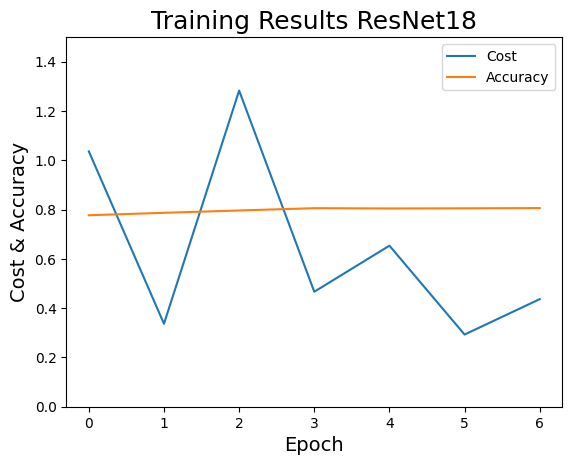

In [30]:
plot_training_results(train_results_resnet18, y_range=(0,1.5), model_title='ResNet18')

# New Models

## Alexnet

Define a model as a pre-trained AlexNet, which is a deep neural network architecture for image recognition

AlexNet was the winner of the ImageNet Large Scale Visual Recognition Challenge in 2012

It has five convolutional layers, three max pooling layers, and three fully connected layers

In [98]:
model_alexnet = models.alexnet(weights=True)
model_alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [99]:
# Loop over each parameter of the AlexNet model
for i, w in enumerate(model_alexnet.parameters()):
    # Print the index, shape, and gradient requirement of the parameter
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 11, 11]) True
1 torch.Size([64]) True
2 torch.Size([192, 64, 5, 5]) True
3 torch.Size([192]) True
4 torch.Size([384, 192, 3, 3]) True
5 torch.Size([384]) True
6 torch.Size([256, 384, 3, 3]) True
7 torch.Size([256]) True
8 torch.Size([256, 256, 3, 3]) True
9 torch.Size([256]) True
10 torch.Size([4096, 9216]) True
11 torch.Size([4096]) True
12 torch.Size([4096, 4096]) True
13 torch.Size([4096]) True
14 torch.Size([1000, 4096]) True
15 torch.Size([1000]) True


Define a model as a copy of the AlexNet model, but without the last layer

The last layer of the AlexNet model is a linear layer that maps the features to 1000 classes

In [100]:
model_alexnet_aux = nn.Sequential(*list(model_alexnet.children()))
# Print the model's structure
model_alexnet_aux

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): AdaptiveAvgPool2d(output_size=(6, 6))
  (2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplac

In [101]:
# Loop over each parameter of the model_alexnet_aux
for i, parameter in enumerate(model_alexnet_aux.parameters()):
    # Set the gradient requirement of the parameter to False
    # This means that the parameter will not be updated during the training process
    # This is useful when we want to freeze the weights of the pre-trained model and only train the new layers that we add
    parameter.requires_grad = False

In [102]:
# Display updated parameters
for i, parameter in enumerate(model_alexnet_aux.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False


##### Remove last layer

By removing the last layer, we can use the model as a feature extractor for other tasks

In [103]:
# Get the last sequential layer
alexnet_last_seq = list(model_alexnet_aux.children())[-1]
alexnet_last_seq

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [104]:
# Remove the last linear layer
alexnet_last_seq = nn.Sequential(
                                  *list(alexnet_last_seq.children())[:-1],
                                  nn.Linear(in_features=4096, out_features= 10, bias= True))
alexnet_last_seq

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [105]:
## Replace the last sequential layer with the modified one
model_alexnet_10cls = nn.Sequential(*list(model_alexnet_aux.children())[:-1], 
                                    nn.Flatten(), 
                                    alexnet_last_seq)
model_alexnet_10cls

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): AdaptiveAvgPool2d(output_size=(6, 6))
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_featur

In [106]:
# Loop over each parameter of the AlexNet model
for i, w in enumerate(model_alexnet_10cls.parameters()):
    # Print the index, shape, and gradient requirement of the parameter
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 11, 11]) False
1 torch.Size([64]) False
2 torch.Size([192, 64, 5, 5]) False
3 torch.Size([192]) False
4 torch.Size([384, 192, 3, 3]) False
5 torch.Size([384]) False
6 torch.Size([256, 384, 3, 3]) False
7 torch.Size([256]) False
8 torch.Size([256, 256, 3, 3]) False
9 torch.Size([256]) False
10 torch.Size([4096, 9216]) False
11 torch.Size([4096]) False
12 torch.Size([4096, 4096]) False
13 torch.Size([4096]) False
14 torch.Size([10, 4096]) True
15 torch.Size([10]) True


In [108]:
lr = 5e-4
epochs = 7

optimiser_alexnet = torch.optim.Adam(model_alexnet_10cls.parameters(), lr=lr, betas=(0.9, 0.999))

model_alexnet_10cls

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): AdaptiveAvgPool2d(output_size=(6, 6))
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_featur

In [109]:
train_results_alexnet = train(model_alexnet_10cls, optimiser_alexnet, epochs)

Epoca 0, costo: 0.5288, accuracy: 0.8058, minutes training: 1.26
Epoca 1, costo: 0.2392, accuracy: 0.8166, minutes training: 1.26
Epoca 2, costo: 0.1006, accuracy: 0.8312, minutes training: 1.26
Epoca 3, costo: 0.6922, accuracy: 0.8304, minutes training: 1.26
Epoca 4, costo: 0.2053, accuracy: 0.8336, minutes training: 1.27
Epoca 5, costo: 0.2557, accuracy: 0.8382, minutes training: 1.26
Epoca 6, costo: 0.1487, accuracy: 0.8342, minutes training: 1.27


In [110]:
accuracy(model_alexnet_10cls, test_loader)

0.8269

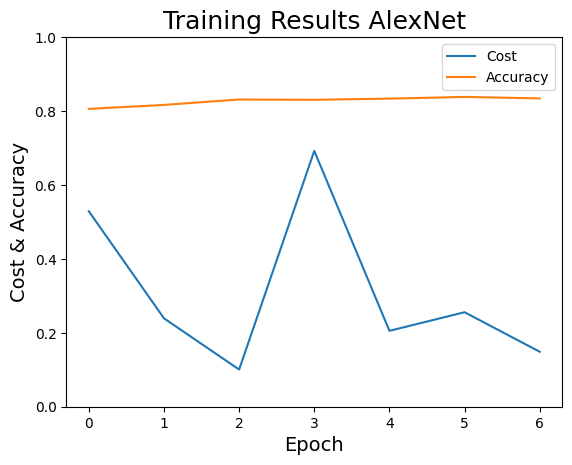

In [111]:
plot_training_results(train_results_alexnet, y_range=(0,1), model_title='AlexNet')

## VGG16

In [112]:
model_vgg16 = models.vgg16(weights=True)

C:\Users\fgarcia24\Anaconda3\envs\mna\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [113]:
for i, w in enumerate(model_vgg16.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 3, 3]) True
1 torch.Size([64]) True
2 torch.Size([64, 64, 3, 3]) True
3 torch.Size([64]) True
4 torch.Size([128, 64, 3, 3]) True
5 torch.Size([128]) True
6 torch.Size([128, 128, 3, 3]) True
7 torch.Size([128]) True
8 torch.Size([256, 128, 3, 3]) True
9 torch.Size([256]) True
10 torch.Size([256, 256, 3, 3]) True
11 torch.Size([256]) True
12 torch.Size([256, 256, 3, 3]) True
13 torch.Size([256]) True
14 torch.Size([512, 256, 3, 3]) True
15 torch.Size([512]) True
16 torch.Size([512, 512, 3, 3]) True
17 torch.Size([512]) True
18 torch.Size([512, 512, 3, 3]) True
19 torch.Size([512]) True
20 torch.Size([512, 512, 3, 3]) True
21 torch.Size([512]) True
22 torch.Size([512, 512, 3, 3]) True
23 torch.Size([512]) True
24 torch.Size([512, 512, 3, 3]) True
25 torch.Size([512]) True
26 torch.Size([4096, 25088]) True
27 torch.Size([4096]) True
28 torch.Size([4096, 4096]) True
29 torch.Size([4096]) True
30 torch.Size([1000, 4096]) True
31 torch.Size([1000]) True


In [114]:
model_vgg16_aux = nn.Sequential(*list(model_vgg16.children()))
model_vgg16_aux

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [115]:
for i, parameter in enumerate(model_vgg16_aux.parameters()):
    parameter.requires_grad = False

In [116]:
for i, parameter in enumerate(model_vgg16_aux.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False


In [117]:
# Get the last sequential layer
vgg16_last_seq = list(model_vgg16_aux.children())[-1]
vgg16_last_seq

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [118]:
# Remove the last linear layer
vgg16_last_seq = nn.Sequential(
                                  *list(vgg16_last_seq.children())[:-1],
                                  nn.Linear(in_features=4096, out_features= 10, bias= True))
vgg16_last_seq

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [119]:
## Replace the last sequential layer with the modified one
model_vgg16_10cls = nn.Sequential(*list(model_vgg16_aux.children())[:-1], 
                                    nn.Flatten(), 
                                    vgg16_last_seq)
model_vgg16_10cls

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [120]:
# Loop over each parameter of the AlexNet model
for i, w in enumerate(model_vgg16_10cls.parameters()):
    # Print the index, shape, and gradient requirement of the parameter
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 3, 3]) False
1 torch.Size([64]) False
2 torch.Size([64, 64, 3, 3]) False
3 torch.Size([64]) False
4 torch.Size([128, 64, 3, 3]) False
5 torch.Size([128]) False
6 torch.Size([128, 128, 3, 3]) False
7 torch.Size([128]) False
8 torch.Size([256, 128, 3, 3]) False
9 torch.Size([256]) False
10 torch.Size([256, 256, 3, 3]) False
11 torch.Size([256]) False
12 torch.Size([256, 256, 3, 3]) False
13 torch.Size([256]) False
14 torch.Size([512, 256, 3, 3]) False
15 torch.Size([512]) False
16 torch.Size([512, 512, 3, 3]) False
17 torch.Size([512]) False
18 torch.Size([512, 512, 3, 3]) False
19 torch.Size([512]) False
20 torch.Size([512, 512, 3, 3]) False
21 torch.Size([512]) False
22 torch.Size([512, 512, 3, 3]) False
23 torch.Size([512]) False
24 torch.Size([512, 512, 3, 3]) False
25 torch.Size([512]) False
26 torch.Size([4096, 25088]) False
27 torch.Size([4096]) False
28 torch.Size([4096, 4096]) False
29 torch.Size([4096]) False
30 torch.Size([10, 4096]) True
31 torch.Size([10

In [121]:
lr = 5e-4
epochs = 7

optimiser_vgg16= torch.optim.Adam(model_vgg16_10cls.parameters(), lr=lr, betas=(0.9, 0.999))

In [122]:
train_results_vgg16 = train(model_vgg16_10cls, optimiser_vgg16, epochs)

Epoca 0, costo: 1.6757, accuracy: 0.828, minutes training: 2.24
Epoca 1, costo: 0.4324, accuracy: 0.8374, minutes training: 2.34
Epoca 2, costo: 0.6469, accuracy: 0.8462, minutes training: 2.28
Epoca 3, costo: 0.7558, accuracy: 0.8534, minutes training: 2.32
Epoca 4, costo: 0.2016, accuracy: 0.8528, minutes training: 2.4
Epoca 5, costo: 0.4071, accuracy: 0.8536, minutes training: 2.41
Epoca 6, costo: 0.5759, accuracy: 0.8532, minutes training: 2.44


In [123]:
accuracy(model_vgg16_10cls, test_loader)

0.839

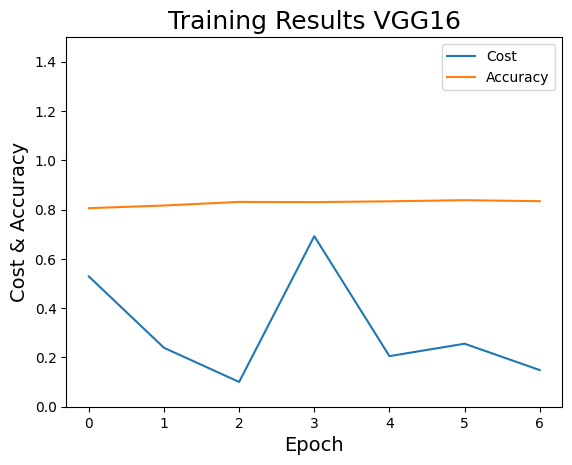

In [124]:
plot_training_results(train_results_alexnet, y_range=(0,1.5), model_title='VGG16')

### **Summary of Using Pre-trained Models on CIFAR-10**:

------

#### **CIFAR-10 Dataset**:

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 different classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

#### **Advantages of Using Pre-trained Models**:

Using pre-trained models, especially ones trained on large datasets like ImageNet, is a powerful method in deep learning known as **transfer learning**. These models already understand a significant portion of the visual world and can be fine-tuned to specific tasks.

Benefits include:

- **Speed**: Significantly faster training.
- **Less Data**: Particularly beneficial if the new dataset is small.
- **Improved Performance**: Features learned from a large dataset can generalize well to other tasks.

#### **Model Descriptions**:

1. **ResNet-18**: Part of the ResNet family, which uses "residual learning" to train very deep networks by using skip connections or shortcuts to jump over some layers. It particularly has 18 layers and is known for its efficiency and performance.

```
markdown
model_resnet18 = models.resnet18(weights=True)
```

1. **AlexNet**: Historically significant as it was the winner of the ImageNet competition in 2012. It has 5 convolutional layers followed by 3 fully connected layers.

```
markdown
model_alexnet = models.alexnet(weights=True)
```

1. **VGG-16**: Known for its simplicity and uniform architecture. It contains 16 layers with weights, consisting of only convolutional and fully connected layers.

```
markdown
# Assume model initialization similar to above models.
```

#### **Challenges and Solutions**:

1. **Model Adaptation for CIFAR-10**:
   - Pretrained models are designed for ImageNet (1,000 classes, 224x224 images). CIFAR-10 has only 10 classes and 32x32 images.
   - Solution: Removing the last layer (which classifies among 1,000 classes) and appending a new layer that classifies among 10 classes.
2. **Modifying Only the Last Layer**:
   - Challenge: PyTorch models are divided into blocks, making layer-specific modifications tricky.
   - Solution:
     1. Modify the last classification block.
     2. Append it back to the original model.

------

#### **Results**:

- **ResNet-18**: Achieved an accuracy of approximately 80.15% on the CIFAR-10 test set.
- **AlexNet**: Achieved an accuracy of around 82.69% on the test set.
- **VGG-16**: Achieved an accuracy of around 83.9% on the test set.

------

### **Concluding Thoughts**:

Transfer learning using pre-trained models on the CIFAR-10 dataset demonstrated significant advantages, showcasing the power of leveraging features from large-scale datasets. While there are challenges, especially in model adaptation, the results underscore the potential of this approach in diverse tasks in computer vision.